# "Converting" normal images to IR

In [1]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt


In [2]:
images_names = glob.glob("image_of_gestures/ir/*.jpg")

In [3]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

827523792


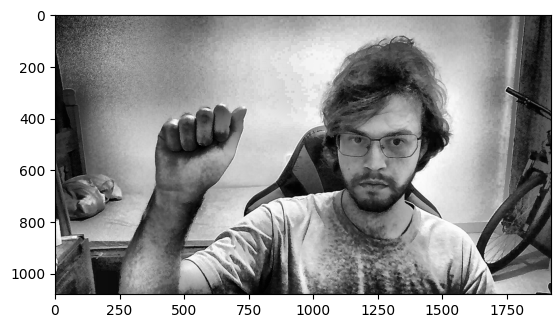

In [4]:
def load_image_as_IR(image_path, rf=False, equalize=True, sharpen=True):
    image = cv2.imread(image_path)
    if sharpen:
        # Define a sharpening kernel
        image = unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0)
    if rf:
        image[:,:,1:3] = 0 # set B and G channels to 0
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if equalize:
        # Apply CLAHE for local histogram equalization
        clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(5, 5))
        image = clahe.apply(image)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    return image[:,:,::-1]

image_gray = load_image_as_IR(images_names[0])
plt.imshow(image_gray, cmap='gray')
print(np.sum(image_gray))


827523792


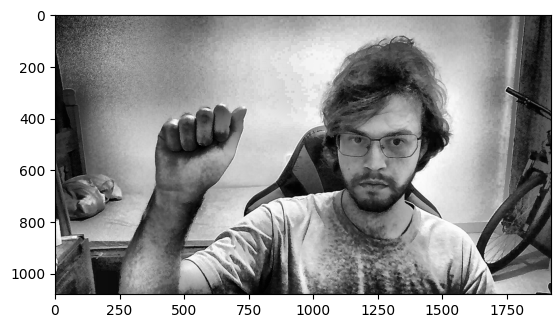

In [5]:
image_rf = load_image_as_IR(images_names[0])
plt.imshow(image_rf)
print(np.sum(image_rf))


## Applying the gesture recognition on the IR images

In [6]:
from gesture.base import Gesture, to_hand_frame
import mediapipe as mp
import math


mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

base_path: str = "./gesture/base_poses_hf"
gestures_names: np.array = Gesture.get_gestures_names()
base_gestures = Gesture.get_base_gestures(gestures_names, base_path)
gestures_names_movements: np.array = Gesture.get_gestures_names_mov()
base_gestures_movements = Gesture.get_base_gestures_accumulated(
    gestures_names_movements, base_path
)
g = Gesture(
    base_gestures=base_gestures,
    base_acc_gestures=base_gestures_movements,
)

/home/roger/Documents/2-Upwork/gesture/shrine-exp/transcribe-asl/gesture/base.py:858: UserWarning: genfromtxt: Empty input file: "./gesture/base_poses_hf/five_Transcription_Pose.csv"
  base_gesture = np.genfromtxt(path, delimiter=",")


In [7]:
def draw_hand_from_kps(right_hand_data_f, image_shape):
    hand_connections = [
        [0, 1, 2, 3, 4],
        [0, 5, 6, 7, 8],
        [0, 9, 10, 11, 12],
        [0, 13, 14, 15, 16],
        [0, 17, 18, 19, 20],
    ]
    right_hand_data_f[:, 0] = right_hand_data_f[:, 0] * image_shape[1]
    right_hand_data_f[:, 1] = right_hand_data_f[:, 1] * image_shape[0]

    for connections in hand_connections:
        for i in range(len(connections) - 1):
            x1, y1, z1 = right_hand_data_f[connections[i]]
            x2, y2, z2 = right_hand_data_f[connections[i + 1]]
            plt.plot((x1, x2), (y1, y2), 'r')

In [10]:
image = load_image_as_IR(images_names[0], rf=True)
img_shape = (1080, 720)
image = cv2.resize(image, img_shape)

with mp_holistic.Holistic(
        model_complexity=1,
        smooth_landmarks=True,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        enable_segmentation=False,
        refine_face_landmarks=True,
        static_image_mode=False,
    ) as holistic:
    
    results = holistic.process(image)

    right_hand_data =  np.array([[el.x, el.y, el.z] for el in results.right_hand_landmarks.landmark])


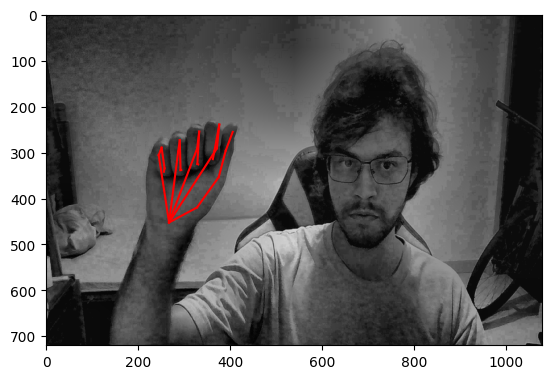

In [11]:
plt.figure()
draw_hand_from_kps(right_hand_data, image.shape)
plt.imshow(image, cmap='gray')